In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libs


In [2]:
!pip install imutils

In [3]:
import numpy as np
import pandas as pd
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
#from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
# import tensorflow as tf
import keras
#from keras.applications.vgg16 import VGG16 
from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
#from keras.initializers import he_normal
# from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
#from keras.preprocessing.image import ImageDataGenerator
import imutils
import itertools

In [4]:
class_names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
nb_classes = len(class_names)

# Load Image


In [5]:
def findEdges(image):
    # find edges in image
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged

In [6]:
def getBoxes(contours, orig):
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (dist.euclidean(tl, bl)) > 0 and (dist.euclidean(tl, tr)) > 0:
            boxes.append(box)
    return boxes

In [7]:
def getImgContours(edged):
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

In [8]:
IMAGE_SIZE = 128
EPOCHS = 50

In [9]:

datasets = ['/content/drive/MyDrive/BME2/dataset2-master/images/TRAIN', '/content/drive/MyDrive/BME2/dataset2-master/images/TEST']
images = []
labels = []
  #lặp qua các folder trong thư mục datasets
count =0
for dataset in datasets:

    for folder in os.listdir(dataset):

        if folder in ['EOSINOPHIL']: label = 0
        elif folder in ['LYMPHOCYTE']: label = 1
        elif folder in ['MONOCYTE']: label = 2
        elif folder in ['NEUTROPHIL']: label = 3

        for file in tqdm(os.listdir(os.path.join(dataset, folder))):

            img_path = os.path.join(os.path.join(dataset, folder), file)

            # Open 
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # add padding to the image to better detect cell at the edge
            image = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])
            
            #thresholding the image to get the target cell
            image1 = cv2.inRange(image,(80, 80, 180),(180, 170, 245))
            
            # openning errosion then dilation
            kernel = np.ones((3, 3), np.uint8)
            kernel1 = np.ones((5, 5), np.uint8)
            img_erosion = cv2.erode(image1, kernel, iterations=2)
            image1 = cv2.dilate(img_erosion, kernel1, iterations=5)
            
            #detecting the blood cell
            edgedImage = findEdges(image1)
            edgedContours = getImgContours(edgedImage)
            edgedBoxes =  getBoxes(edgedContours, image.copy())
            if len(edgedBoxes)==0:
                count +=1
                continue
            # get the large box and get its cordinate
            last = edgedBoxes[-1]
            max_x = int(max(last[:,0]))
            min_x = int( min(last[:,0]))
            max_y = int(max(last[:,1]))
            min_y = int(min(last[:,1]))
            
            # draw the contour and fill it 
            mask = np.zeros_like(image)
            cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1) 
            
            # any pixel but the pixels inside the contour is zero
            image[mask==0] = 0
            
            # extract th blood cell
            image = image[min_y:max_y, min_x:max_x]

            if (np.size(image)==0):
                count +=1
                continue
            # resize th image
            image = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE))

            # Append the image and its corresponding label to the output
            images.append(image)
            labels.append(label)

images = np.array(images, dtype = 'float32')
labels = np.array(labels, dtype = 'int32')

# return images, labels


100%|██████████| 620/620 [03:51<00:00,  2.67it/s]


In [10]:
print(len(images))
print(len(labels))

12146
12146


In [11]:
images, labels = shuffle(images, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

In [12]:
print(len(train_images))
print(len(train_labels))
print(len(val_images))
print(len(val_labels))
print(len(test_images))
print(len(test_labels))

9716
9716
1215
1215
1215
1215


In [13]:

print("Training images: {}".format(train_images.shape))
print("Training labels: {}".format(train_labels.shape))
print("Validation images: {}".format(val_images.shape))
print("Validation labels: {}".format(val_labels.shape))
print("Test images: {}".format(test_images.shape))
print("Test labels: {}".format(test_labels.shape))

Training images: (9716, 128, 128, 3)
Training labels: (9716,)
Validation images: (1215, 128, 128, 3)
Validation labels: (1215,)
Test images: (1215, 128, 128, 3)
Test labels: (1215,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9716


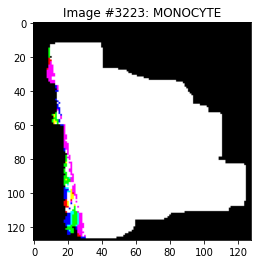

In [14]:
#hiển thị train image  
print(len(train_images))
index = np.random.randint(train_images.shape[0])
plt.figure()
plt.imshow(train_images[index])
plt.title('Image #{}: '.format(index) + class_names[train_labels[index]])
plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Ground Truth : 0')

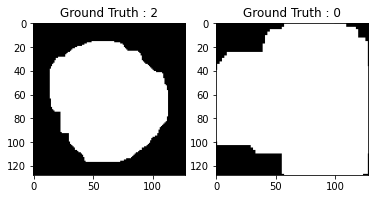

In [15]:
# Ground truth
# Hiển thị ảnh từ train data
plt.subplot(121)
index = np.random.randint(train_images.shape[0])
plt.imshow(train_images[index,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_labels[index]))

# Hiển thị ảnh từ test data
plt.subplot(122)
index = np.random.randint(test_images.shape[0])
plt.imshow(test_images[index,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_labels[index]))



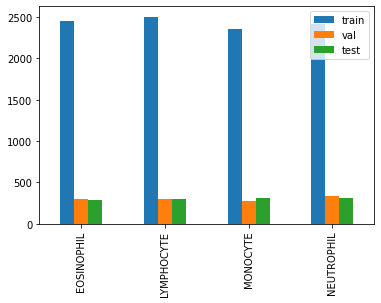

In [16]:
_, train_counts = np.unique(train_labels, return_counts = True)
_, val_counts = np.unique(val_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)

pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = class_names).plot.bar()

plt.show()

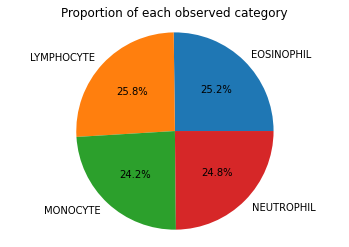

In [17]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9716


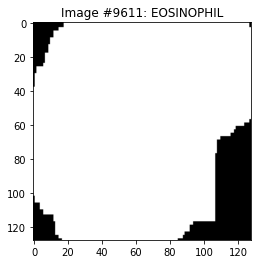

In [18]:
def display_random_image (class_names, images, labels):
    print(len(images))
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image (class_names, train_images, train_labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

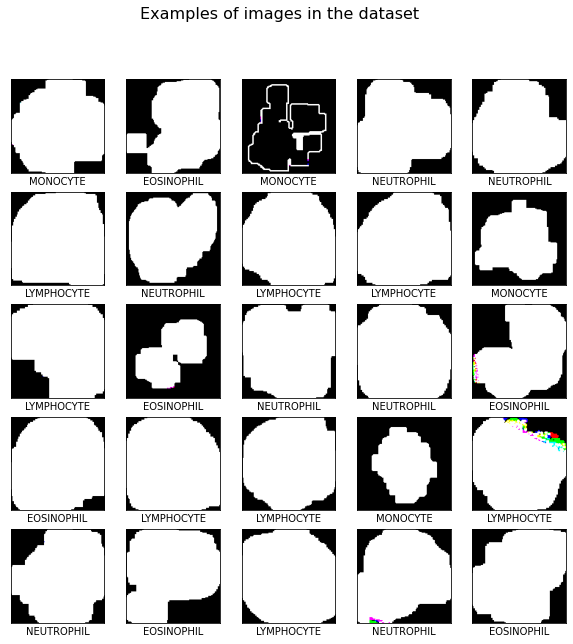

In [19]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

# EfficientNetV2


In [22]:
#Normalization
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Activation,
    Add,
    BatchNormalization,
    Conv2D,
    Dense,
    DepthwiseConv2D,
    Dropout,
    GlobalAveragePooling2D,
    Input,
    PReLU,
    Reshape,
    Multiply,
)

In [24]:
BATCH_NORM_DECAY = 0.9
BATCH_NORM_EPSILON = 0.001
CONV_KERNEL_INITIALIZER = keras.initializers.VarianceScaling(scale=2.0, mode="fan_out", distribution="truncated_normal")
# CONV_KERNEL_INITIALIZER = 'glorot_uniform'

BLOCK_CONFIGS = {
    "b0": {
        "first_conv_filter": 32,
        "expands": [1, 4, 4, 4, 6, 6],
        "out_channels": [16, 32, 48, 96, 112, 192],
        "depthes": [1, 2, 2, 3, 5, 8],
        "strides": [1, 2, 2, 2, 1, 2],
        "use_ses": [0, 0, 0, 1, 1, 1],
    },
    "b1": {
        "first_conv_filter": 32,
        "expands": [1, 4, 4, 4, 6, 6],
        "out_channels": [16, 32, 48, 96, 112, 192],
        "depthes": [2, 3, 3, 4, 6, 9],
        "strides": [1, 2, 2, 2, 1, 2],
        "use_ses": [0, 0, 0, 1, 1, 1],
    },
    "b2": {
        "first_conv_filter": 32,
        "output_conv_filter": 1408,
        "expands": [1, 4, 4, 4, 6, 6],
        "out_channels": [16, 32, 56, 104, 120, 208],
        "depthes": [2, 3, 3, 4, 6, 10],
        "strides": [1, 2, 2, 2, 1, 2],
        "use_ses": [0, 0, 0, 1, 1, 1],
    },
    "b3": {
        "first_conv_filter": 40,
        "output_conv_filter": 1536,
        "expands": [1, 4, 4, 4, 6, 6],
        "out_channels": [16, 40, 56, 112, 136, 232],
        "depthes": [2, 3, 3, 5, 7, 12],
        "strides": [1, 2, 2, 2, 1, 2],
        "use_ses": [0, 0, 0, 1, 1, 1],
    },
    "s": {
        "first_conv_filter": 24,
        "output_conv_filter": 1280,
        "expands": [1, 4, 4, 4, 6, 6],
        "out_channels": [24, 48, 64, 128, 160, 256],
        "depthes": [2, 4, 4, 6, 9, 15],
        "strides": [1, 2, 2, 2, 1, 2],
        "use_ses": [0, 0, 0, 1, 1, 1],
    },
    "m": {
        "first_conv_filter": 24,
        "output_conv_filter": 1280,
        "expands": [1, 4, 4, 4, 6, 6, 6],
        "out_channels": [24, 48, 80, 160, 176, 304, 512],
        "depthes": [3, 5, 5, 7, 14, 18, 5],
        "strides": [1, 2, 2, 2, 1, 2, 1],
        "use_ses": [0, 0, 0, 1, 1, 1, 1],
    },
    "l": {
        "first_conv_filter": 32,
        "output_conv_filter": 1280,
        "expands": [1, 4, 4, 4, 6, 6, 6],
        "out_channels": [32, 64, 96, 192, 224, 384, 640],
        "depthes": [4, 7, 7, 10, 19, 25, 7],
        "strides": [1, 2, 2, 2, 1, 2, 1],
        "use_ses": [0, 0, 0, 1, 1, 1, 1],
    },
}

In [25]:
def _make_divisible(v, divisor=4, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def conv2d_no_bias(inputs, filters, kernel_size, strides=1, padding="VALID"):
    return Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=False, kernel_initializer=CONV_KERNEL_INITIALIZER
    )(inputs)


def batchnorm_with_activation(inputs, activation="swish"):
    """Performs a batch normalization followed by an activation. """
    bn_axis = 1 if K.image_data_format() == "channels_first" else -1
    nn = BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
    )(inputs)
    if activation:
        nn = Activation(activation=activation)(nn)
        # nn = PReLU(shared_axes=[1, 2], alpha_initializer=tf.initializers.Constant(0.25))(nn)
    return nn


def se_module(inputs, se_ratio=4):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    h_axis, w_axis = [2, 3] if K.image_data_format() == "channels_first" else [1, 2]

    filters = inputs.shape[channel_axis]
    # reduction = _make_divisible(filters // se_ratio, 8)
    reduction = filters // se_ratio
    # se = GlobalAveragePooling2D()(inputs)
    # se = Reshape((1, 1, filters))(se)
    se = tf.reduce_mean(inputs, [h_axis, w_axis], keepdims=True)
    se = Conv2D(reduction, kernel_size=1, use_bias=True, kernel_initializer=CONV_KERNEL_INITIALIZER)(se)
    # se = PReLU(shared_axes=[1, 2])(se)
    se = Activation("swish")(se)
    se = Conv2D(filters, kernel_size=1, use_bias=True, kernel_initializer=CONV_KERNEL_INITIALIZER)(se)
    se = Activation("sigmoid")(se)
    return Multiply()([inputs, se])


def MBConv(inputs, output_channel, stride, expand_ratio, shortcut, survival=None, use_se=0, is_fused=False):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    input_channel = inputs.shape[channel_axis]

    if is_fused and expand_ratio != 1:
        nn = conv2d_no_bias(inputs, input_channel * expand_ratio, (3, 3), strides=stride, padding="same")
        nn = batchnorm_with_activation(nn)
    elif expand_ratio != 1:
        nn = conv2d_no_bias(inputs, input_channel * expand_ratio, (1, 1), strides=(1, 1), padding="same")
        nn = batchnorm_with_activation(nn)
    else:
        nn = inputs

    if not is_fused:
        nn = DepthwiseConv2D(
            (3, 3), padding="same", strides=stride, use_bias=False, depthwise_initializer=CONV_KERNEL_INITIALIZER
        )(nn)
        nn = batchnorm_with_activation(nn)

    if use_se:
        nn = se_module(nn, se_ratio=4 * expand_ratio)

    # pw-linear
    if is_fused and expand_ratio == 1:
        nn = conv2d_no_bias(nn, output_channel, (3, 3), strides=stride, padding="same")
        nn = batchnorm_with_activation(nn)
    else:
        nn = conv2d_no_bias(nn, output_channel, (1, 1), strides=(1, 1), padding="same")
        nn = batchnorm_with_activation(nn, activation=None)

    if shortcut:
        if survival is not None and survival < 1:
            from tensorflow_addons.layers import StochasticDepth

            return StochasticDepth(float(survival))([inputs, nn])
        else:
            return Add()([inputs, nn])
    else:
        return nn

In [26]:
def EfficientNetV2(
    model_type,
    input_shape,
    classes,
    dropout=0.2,
    first_strides=2,
    survivals=None,
    classifier_activation="softmax",
    name="EfficientNetV2",
    ):
    """
    model_type: is the pre-defined model, value in ["s", "m", "l", "b0", "b1", "b2", "b3"].
    first_strides: is used in the first Conv2D layer.
    survivals: is used for [Deep Networks with Stochastic Depth](https://arxiv.org/abs/1603.09382).
        Can be a constant value like `0.5` or `0.8`,
        or a tuple value like `(1, 0.8)` indicates the survival probability linearly changes from `1 --> 0.8` for `top --> bottom` layers.
        A higher value means a higher probability will keep the conv branch.
        or `None` to disable.
    """
    blocks_config = BLOCK_CONFIGS.get(model_type.lower(), BLOCK_CONFIGS["s"])
    expands = blocks_config["expands"]
    out_channels = blocks_config["out_channels"]
    depthes = blocks_config["depthes"]
    strides = blocks_config["strides"]
    use_ses = blocks_config["use_ses"]
    first_conv_filter = blocks_config.get("first_conv_filter", out_channels[0])
    output_conv_filter = blocks_config.get("output_conv_filter", 1280)

    inputs = Input(shape=input_shape)
    out_channel = _make_divisible(first_conv_filter, 8)
    nn = conv2d_no_bias(inputs, out_channel, (3, 3), strides=first_strides, padding="same")
    nn = batchnorm_with_activation(nn)

    # StochasticDepth survival_probability values
    total_layers = sum(depthes)
    if isinstance(survivals, float):
        survivals = [survivals] * total_layers
    elif isinstance(survivals, (list, tuple)) and len(survivals) == 2:
        start, end = survivals
        survivals = [start - (1 - end) * float(ii) / total_layers for ii in range(total_layers)]
    else:
        survivals = [None] * total_layers
    survivals = [survivals[int(sum(depthes[:id])) : sum(depthes[: id + 1])] for id in range(len(depthes))]

    pre_out = out_channel
    for expand, out_channel, depth, survival, stride, se in zip(expands, out_channels, depthes, survivals, strides, use_ses):
        out = _make_divisible(out_channel, 8)
        is_fused = True if se == 0 else False
        for ii in range(depth):
            stride = stride if ii == 0 else 1
            shortcut = True if out == pre_out and stride == 1 else False
            nn = MBConv(nn, out, stride, expand, shortcut, survival[ii], se, is_fused)
            pre_out = out

    output_conv_filter = _make_divisible(output_conv_filter, 8)
    nn = conv2d_no_bias(nn, output_conv_filter, (1, 1), strides=(1, 1), padding="valid")
    nn = batchnorm_with_activation(nn)

    if classes > 0:
        nn = GlobalAveragePooling2D(name="avg_pool")(nn)
        if dropout > 0 and dropout < 1:
            nn = Dropout(dropout)(nn)
        nn = Dense(classes, activation=classifier_activation, name="predictions")(nn)
    return Model(inputs=inputs, outputs=nn, name=name)

In [27]:
model = EfficientNetV2(
    model_type="b3",
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    classes=4,
    dropout=0.2,
    first_strides=2,
    survivals=None,
    classifier_activation="softmax",
    name="EfficientNetV2",
)
model.summary()

Model: "EfficientNetV2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 40)   1080        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 40)   160         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 40)   0           batch_normalization[0][0]        
_____________________________________________________________________________________

In [28]:
print(len(model.layers))

408


In [30]:
model.compile(optimizer = "adam" , 
               loss = 'sparse_categorical_crossentropy' , 
               metrics = ['accuracy'])
# model.summary()

callback1 = ModelCheckpoint(filepath='best_model.hdf5', save_best_only=True, save_weights_only=False)
callback2 = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)
callback3 = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)

history = model.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = EPOCHS, 
    validation_data=(val_images, val_labels), 
    callbacks=[callback1, callback3]
    )

Epoch 1/50
304/304 [==============================] - 58s 156ms/step - loss: 0.4512 - accuracy: 0.8369 - val_loss: 0.4669 - val_accuracy: 0.8230


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
304/304 [==============================] - 45s 148ms/step - loss: 0.2603 - accuracy: 0.9066 - val_loss: 0.2904 - val_accuracy: 0.9037
Epoch 3/50
304/304 [==============================] - 44s 144ms/step - loss: 0.1761 - accuracy: 0.9338 - val_loss: 0.4957 - val_accuracy: 0.8469
Epoch 4/50
304/304 [==============================] - 44s 144ms/step - loss: 0.1504 - accuracy: 0.9446 - val_loss: 0.2431 - val_accuracy: 0.9111
Epoch 5/50
304/304 [==============================] - 44s 144ms/step - loss: 0.1375 - accuracy: 0.9505 - val_loss: 0.2305 - val_accuracy: 0.9078
Epoch 6/50
304/304 [==============================] - 45s 148ms/step - loss: 0.0872 - accuracy: 0.9696 - val_loss: 0.3221 - val_accuracy: 0.8905

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/50
304/304 [==============================] - 44s 144ms/step - loss: 0.0369 - accuracy: 0.9865 - val_loss: 0.0749 - val_accuracy: 0.9745
Epoch 8/50
304/304 [=============================

In [31]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(EPOCHS)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()


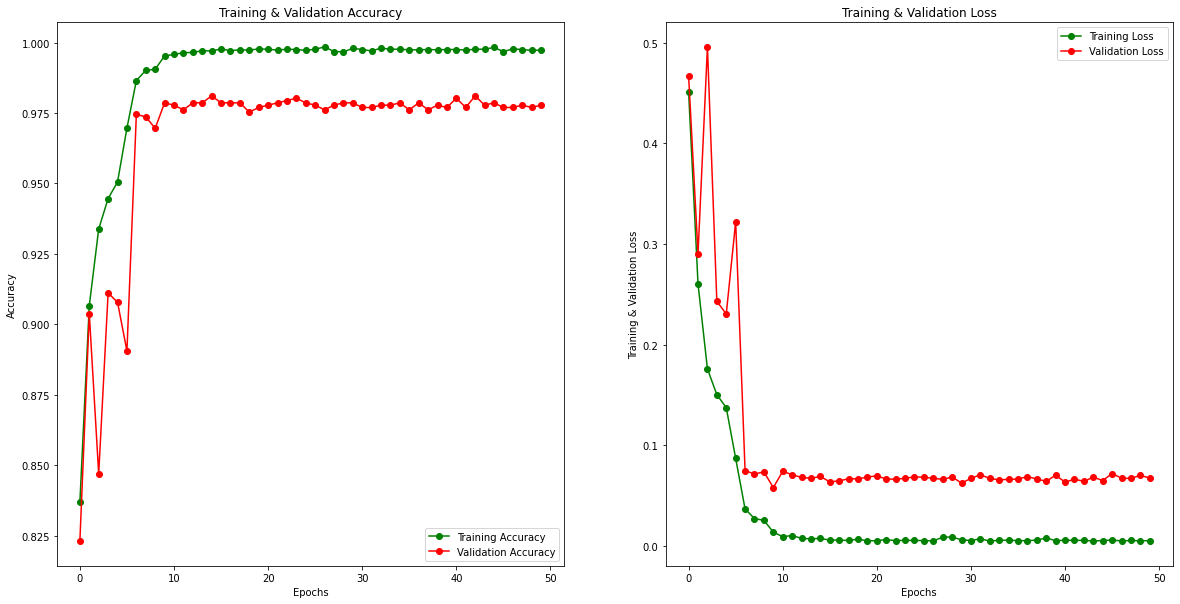

In [32]:
plot_accuracy_loss_chart(history)

In [34]:
results = model.evaluate(test_images, test_labels)

print("Loss of test model is  ", results[0])
print("Accuracy of test model is ", results[1]*100, "%")


results = model.evaluate(val_images, val_labels)

print("Loss of validation model is ", results[0])
print("Accuracy of validation model is ", results[1]*100, "%")

results = model.evaluate(train_images, train_labels)

print("Loss of train model  is ", results[0])
print("Accuracy of train model is ", results[1]*100, "%")

38/38 [==============================] - 2s 41ms/step - loss: 0.0327 - accuracy: 0.9885
Loss of test model is   0.03268973529338837
Accuracy of test model is  98.8477349281311 %
38/38 [==============================] - 1s 38ms/step - loss: 0.0675 - accuracy: 0.9778
Loss of validation model is  0.06754099577665329
Accuracy of validation model is  97.77777791023254 %
304/304 [==============================] - 12s 38ms/step - loss: 0.0043 - accuracy: 0.9983
Loss of train model  is  0.004282092675566673
Accuracy of train model is  99.82503056526184 %


In [36]:
from sklearn.metrics import classification_report

predictions = model.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

array([0, 3, 1, 1, 0, 2, 2, 3, 1, 2, 1, 2, 1, 3, 1])

In [37]:
print(classification_report(
    test_labels, 
    predictions, 
    target_names = ['EOSINOPHIL (Nhom 0)', 'LYMPHOCYTE (Nhom 1)', 'MONOCYTE (Nhom 2)', 'NEUTROPHIL (Nhom 3)']))

                     precision    recall  f1-score   support

EOSINOPHIL (Nhom 0)       0.98      0.98      0.98       291
LYMPHOCYTE (Nhom 1)       1.00      1.00      1.00       301
  MONOCYTE (Nhom 2)       0.99      0.99      0.99       308
NEUTROPHIL (Nhom 3)       0.99      0.99      0.99       315

           accuracy                           0.99      1215
          macro avg       0.99      0.99      0.99      1215
       weighted avg       0.99      0.99      0.99      1215



In [38]:
cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3'], columns = ['0', '1', '2', '3'])
cm

,0,1,2,3
0,285,0,4,2
1,0,301,0,0
2,3,0,304,1
3,4,0,0,311


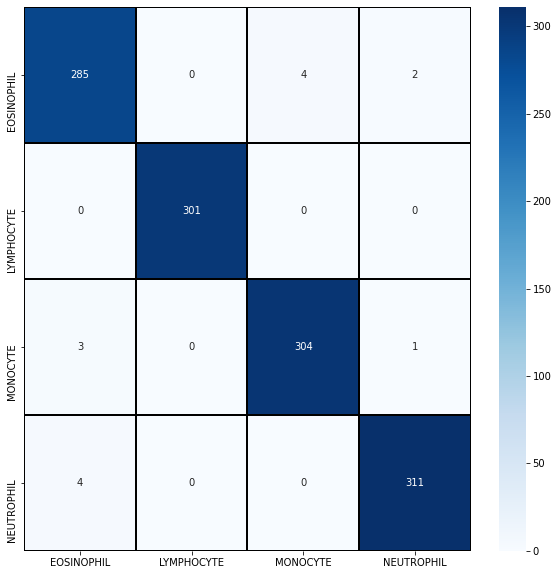

In [39]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)